In [1]:
import fceulib
import ppu_dump
import sys
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# rom = "mario.nes"
# movie = "mario.fm2"
# start_t = 373
rom = "metroid.nes"
movie = "metroid.fm2"
start_t = 518+39
# rom = "metroid.nes"
# movie = "metroid-long.fm2"
# start_t = 4600
# rom = "smb2u.nes"
# movie = "smb2u.fm2"
# start_t = 600
emu = fceulib.runGame(rom)
inputs = fceulib.readInputs(movie)
for i in inputs[:start_t]:
    emu.stepFull(i, 0x0)

NTS:
3 2 
1 0
M 1 base 3
Sc2: 24 0
Match1 0.119288511574 1.0 (21, 23) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 23 0
Match1 0.118919990957 1.0 (0, 24) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 22 30
Match1 0.11557662487 1.0 (19, 23) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 21 0
Match1 0.10851445049 0.999999940395 (0, 24) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 20 0
Match1 0.0991503670812 1.0 (0, 24) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
3 2 
1 0
M 1 base 3
Sc2: 20 0


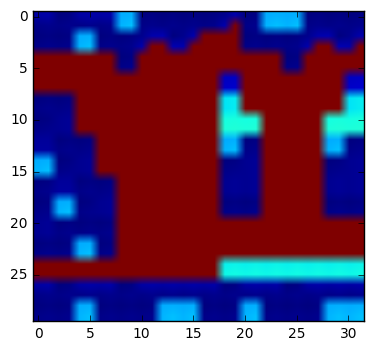

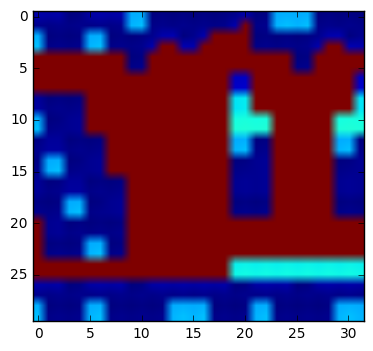

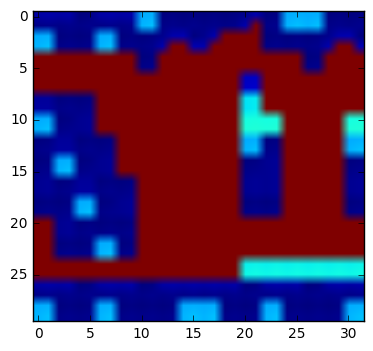

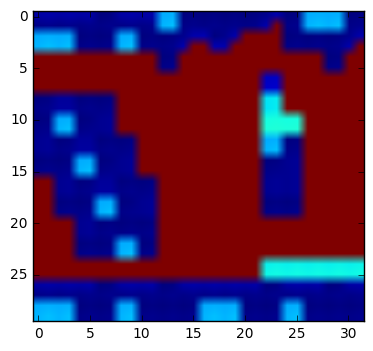

In [10]:
reload(ppu_dump)
ep_data = ppu_dump.ppu_output(emu,
                              inputs[start_t:start_t+30],
                              bg_data=True,
                              scrolling=True,
                              sprite_data=False,
                              colorized_tiles=False,
                              display=False)
nt = ep_data["nametables"][0]
plt.imshow(nt)
plt.show()
nt = ep_data["nametables"][1]
plt.imshow(nt)
plt.show()
nt = ep_data["nametables"][2]
plt.imshow(nt)
plt.show()

nt = ep_data["nametables"][-1]
plt.imshow(nt)
plt.show()

In [ ]:
for i in range(0, 15):
    plt.imshow(ep_data["nametables"][i])
    plt.show()

In [ ]:
posx, posy = 0, 0
nt_total = {}
for t, (sx, sy) in ep_data["screen_motion"].items():
    nt = ep_data["nametables"][t]
    posx += sx
    posy += sy
    print "t", t, "scroll by", sx, sy, posx, posy
    tilex = posx / 8
    tiley = posy / 8
    for x in range(0, 32):
        for y in range(0, 30):
            nt_total[(y+tiley, x+tilex)] = nt[y, x]
minx = min(nt_total.keys().map(lambda x, y: x))
maxx = max(nt_total.keys().map(lambda x, y: x))+1
miny = min(nt_total.keys().map(lambda x, y: y))
maxy = max(nt_total.keys().map(lambda x, y: y))+1
nt_result = np.zeros(shape=(maxy-miny, maxx-minx))
for x in range(minx, maxx):
    for y in range(miny, maxy):
        nt_result[miny+y, minx+x] = nt_total[(y, x)]
colorized = ep_data["tile2colorized"]
out_image = np.zeros(shape=((maxy-miny)*8, (maxx-minx)*8, 4))
for x in range(0, maxx-minx):
    for y in range(0, maxy-miny):
        out_image[y*8, x*8, :] = colorized[nt_result[y, x]]
outImg = Image.fromBytes("RGBA",
                         (maxx-minx, maxy-miny),
                         str(bytearray(out_image)))
outImg.save(outputname+".png")